In [1]:
import configparser
#!pip install boto3
import boto3
import pandas as pd


config = configparser.ConfigParser()
config.read('aws.cfg')

aws_access_key = config['AWS']['aws_access_key_id']
aws_secret_key = config['AWS']['aws_secret_access_key']

s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key,
    aws_secret_access_key=aws_secret_key
)



response = s3.list_buckets()
print('Existing buckets:')
for bucket in response['Buckets']:
    print(f'  {bucket["Name"]}')

Existing buckets:
  alina-week6-bucket
  amsu-aws-s3-assessment
  amsu-s3-cf-website
  andrea-lm-code-bucket
  andy-wrangler-bucket
  apiproject-build-bucket-su05297
  aryan-techcatalyst-awswrangler-lab
  aryan-techcatalyst-lab
  austin-lambda-s3
  aws-athena-query-results-535146832369-us-east-1
  aws-athena-query-results-535146832369-us-east-2
  aws-athena-query-results-535146832369-us-west-2
  aws-athena-query-results-us-east-1-535146832369
  aws-athena-query-results-us-east-1-535146832369nh
  aws-athena-query-results-us-east-1-tarek
  aws-athena-query-results-us-east-2-535146832369
  aws-athena-query-results-us-east-2-535146832369-kb
  aws-athena-query-results-us-east-2-535146832369ab
  aws-cloudtrail-logs-535146832369-01f575cd
  aws-cloudtrail-logs-535146832369-9d19bcae
  aws-glue-assets-535146832369-us-east-1
  aws-glue-assets-535146832369-us-east-2
  aws-glue-assets-535146832369-us-west-2
  aws-logs-535146832369-us-east-1
  aws-sam-cli-managed-default-samclisourcebucket-1oz2tqbsd

In [19]:
bucket_name = "techcatalyst-public"
filepath_p = "resources/sentiment/product.csv"
filepath_r = "resources/sentiment/review.csv"

key_p = "product.csv"
key_r = "review.csv"

product = s3.download_file(bucket_name, filepath_p, key_p)
review = s3.download_file(bucket_name, filepath_r, key_r)



In [20]:
import pandas as pd

product_df = pd.read_csv(key_p)
review_df = pd.read_csv(key_r)

In [4]:
product_df.head()

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID
0,1,High-quality smartphone with excellent camera.,R1
1,1,High-quality smartphone with excellent camera.,R2
2,2,Durable laptop with long battery life.,R3
3,2,Durable laptop with long battery life.,R4
4,3,Wireless noise-canceling headphones.,R5


In [5]:
review_df.head()

,REVIEW ID,REVIEW TEXT
0,R1,"Great camera quality, but battery life could b..."
1,R2,Very satisfied with this smartphone. Worth eve...
2,R3,Excellent performance and battery life. Highly...
3,R4,Disappointed with the build quality. Feels cheap.
4,R5,Fantastic noise cancellation and sound quality.


In [21]:
combined_df = pd.merge(product_df, review_df, on='REVIEW ID', how="inner")
combined_df.head()

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b..."
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...
3,2,Durable laptop with long battery life.,R4,Disappointed with the build quality. Feels cheap.
4,3,Wireless noise-canceling headphones.,R5,Fantastic noise cancellation and sound quality.


In [22]:
comprehend = boto3.client(service_name="comprehend", region_name = "us-west-2", aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_key)

def retrieve_sentiment(r_text):
    sentiment = comprehend.detect_sentiment(Text=r_text, LanguageCode='en')
    return sentiment['Sentiment']

combined_df['SENTIMENT'] = combined_df['REVIEW TEXT'].apply(lambda x: retrieve_sentiment(str(x)))

combined_df.head()

,PRODUCT ID,PRODUCT DESCRIPTION,REVIEW ID,REVIEW TEXT,SENTIMENT
0,1,High-quality smartphone with excellent camera.,R1,"Great camera quality, but battery life could b...",MIXED
1,1,High-quality smartphone with excellent camera.,R2,Very satisfied with this smartphone. Worth eve...,POSITIVE
2,2,Durable laptop with long battery life.,R3,Excellent performance and battery life. Highly...,POSITIVE
3,2,Durable laptop with long battery life.,R4,Disappointed with the build quality. Feels cheap.,NEGATIVE
4,3,Wireless noise-canceling headphones.,R5,Fantastic noise cancellation and sound quality.,POSITIVE


In [10]:
#!pip install matplotlib

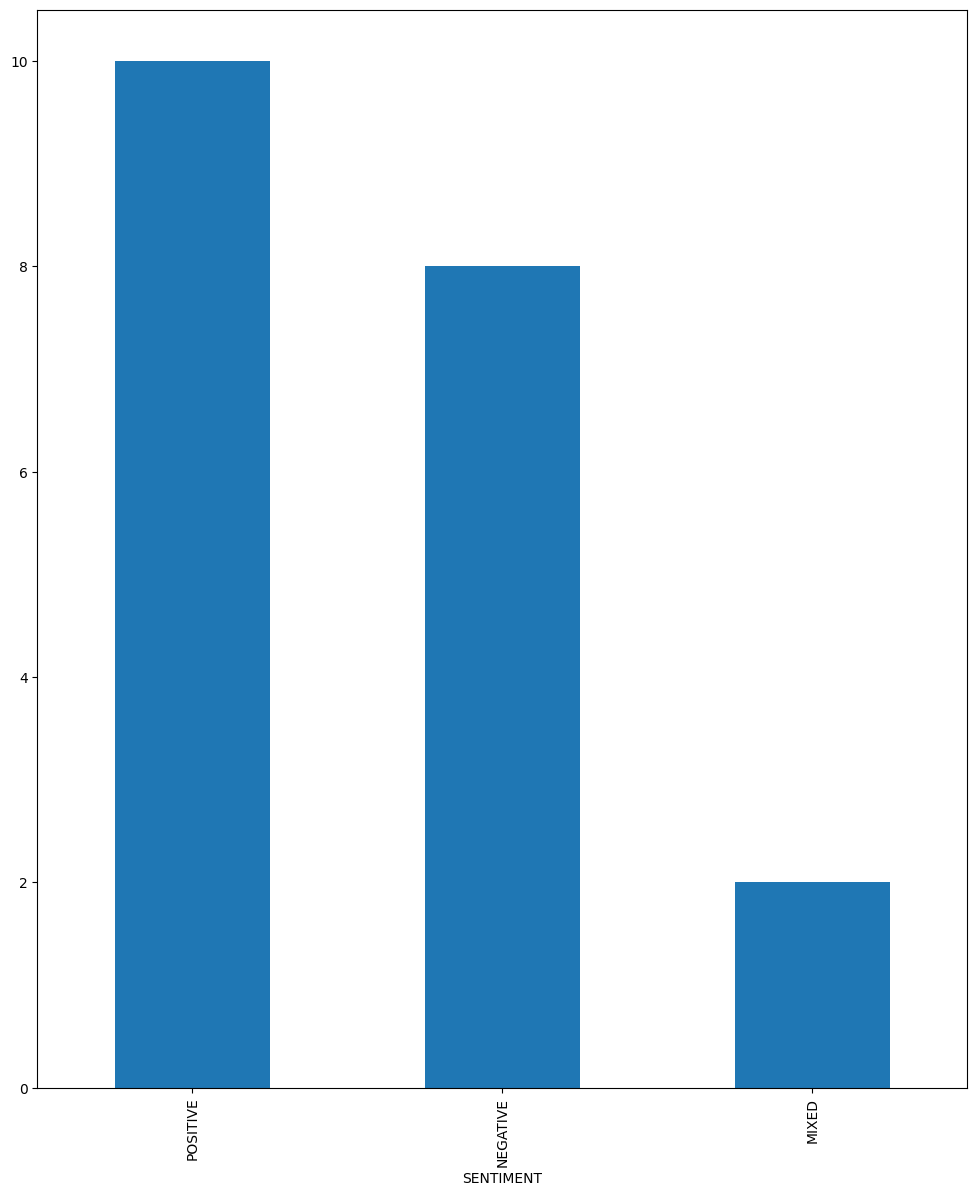

In [24]:
from matplotlib import pyplot as plt

plt.figure(figsize=(12, 14))
combined_df.SENTIMENT.value_counts().plot(kind="bar")
plt.savefig('sentiment_analysis.jpg', format='jpg')

In [25]:
filename_sentiment_image = 'sentiment_analysis.jpg'
bucket_sentiment_image = 'techcatalyst-public'
key_sentiment_image = 'jason/sentiment_analysis.jpg'
s3.upload_file(filename_sentiment_image, bucket_sentiment_image, key_sentiment_image)

In [13]:
combined_df.to_csv('product_sentiment.csv', index=False)

In [15]:
filename_combined = 'product_sentiment.csv'
bucket_combined = 'techcatalyst-public'
key_combined = 'jason/product_sentiment.csv'
s3.upload_file(filename_combined, bucket_combined, key_combined)

In [3]:
import boto3
rekognition = boto3.client(service_name="rekognition", region_name = "us-west-2", aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_key)


s3_b = boto3.resource("s3", aws_access_key_id=aws_access_key, aws_secret_access_key=aws_secret_key)
bucket_name = s3_b.Bucket("techcatalyst-public")
filepath_lp = "resources/license-plates/"


#license_plates = s3.download_file(bucket_name, filepath_lp)

prefix = "resources/license-plates/"
#prefix_objs = s3.list_objects_v2(Bucket=bucket_name, Prefix=prefix).get("Contents")

prefix_objs = bucket_name.objects.filter(Prefix=prefix)

print(prefix_objs)
bucket = "techcatalyst-public"

filepath_list = []

for obj in prefix_objs:
    filepath = filepath_lp
    key = obj.key
    key = str(key).split('/')[2]

    filepath = filepath + key

    if '.' not in str(filepath):
        continue

    if '.csv' in str(filepath):
        continue

    filepath_list.append(str(filepath))
    
    #response = s3.download_file(bucket, filepath, key)
    

for f in filepath_list:
    print(f)


s3.Bucket.objectsCollection(s3.Bucket(name='techcatalyst-public'), s3.ObjectSummary)
resources/license-plates/license_plate10.jpeg
resources/license-plates/license_plate11.png
resources/license-plates/license_plate12.jpeg
resources/license-plates/license_plate13.jpeg
resources/license-plates/license_plate3.png
resources/license-plates/license_plate4.jpeg
resources/license-plates/license_plate6.jpeg
resources/license-plates/license_plate7.jpg
resources/license-plates/license_plate8.png
resources/license-plates/license_plate9.jpeg


In [4]:
import csv

states_list = []

with open('states.csv','r') as data:
   for line in csv.reader(data):
        states_list.append(line[0].upper())



bucket_name = "techcatalyst-public"



summary_dict = {}

for f in filepath_list:
    text = rekognition.detect_text(Image={'S3Object':{'Bucket': bucket_name,'Name': f}})
    detection = text['TextDetections']
    if detection[0]['DetectedText'] not in states_list:
        for i in detection:
            if i['DetectedText'].upper() in states_list:
                summary_dict[f] = i['DetectedText'].upper()
                break
    else:
        summary_dict[f] = detection[0]['DetectedText']



summary_df = pd.DataFrame(list(zip(summary_dict.keys(),summary_dict.values())), columns=['Image','State'])

print(summary_df)


                                           Image          State
0  resources/license-plates/license_plate10.jpeg        ARIZONA
1   resources/license-plates/license_plate11.png          TEXAS
2  resources/license-plates/license_plate12.jpeg          TEXAS
3  resources/license-plates/license_plate13.jpeg        ALABAMA
4    resources/license-plates/license_plate3.png  MASSACHUSETTS
5   resources/license-plates/license_plate4.jpeg   PENNSYLVANIA
6   resources/license-plates/license_plate6.jpeg     CALIFORNIA
7    resources/license-plates/license_plate7.jpg         NEVADA
8    resources/license-plates/license_plate8.png           OHIO
9   resources/license-plates/license_plate9.jpeg        ALABAMA


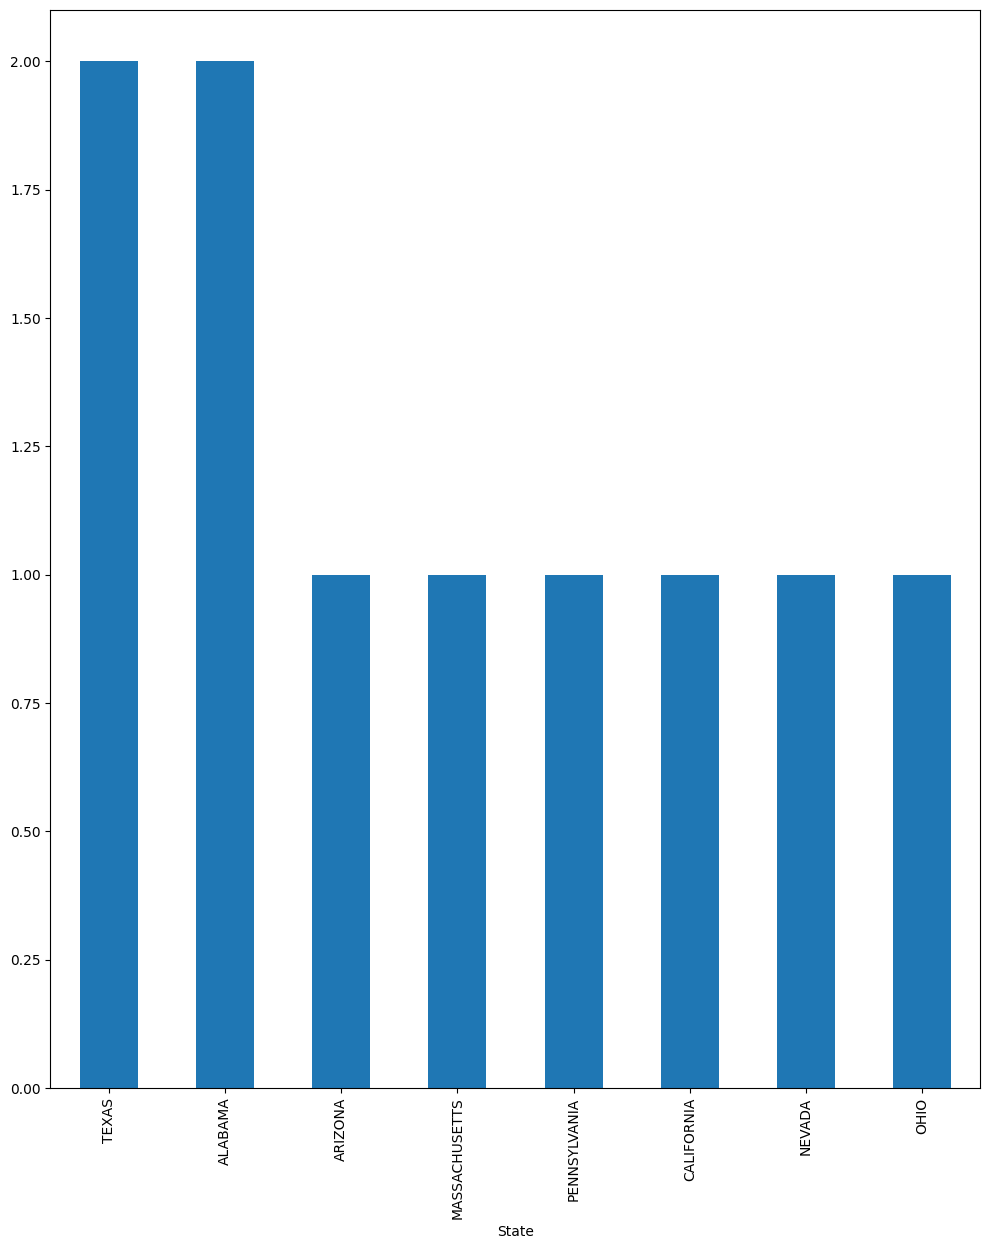

In [15]:

from matplotlib import pyplot as plt


plt.figure(figsize=(12, 14))
summary_df.State.value_counts().plot(kind="bar")
plt.savefig('license_plate.jpg', format='jpg')

In [16]:
filename_lp = 'license_plate.jpg'
bucket_lp = 'techcatalyst-public'
key_lp = 'jason/license_plate.jpg'
s3.upload_file(filename_lp, bucket_lp, key_lp)